# Preparação

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# requirements:

# análise e manipulação de dados
import pandas as pd
import numpy as np

# visualização de dados
import matplotlib.pyplot as plt
import seaborn as sns

# pré-processamento de dados
from sklearn.preprocessing import StandardScaler

# redução de dimensionalidade
from sklearn.decomposition import PCA

# modelos de ML
from sklearn.neural_network import MLPClassifier
from sklearn.cluster import KMeans, AgglomerativeClustering

# avaliação de modelos
from sklearn.model_selection import StratifiedGroupKFold, cross_val_score, cross_val_predict
from sklearn.metrics import (
    confusion_matrix, classification_report, roc_auc_score,
    roc_curve, silhouette_score
)
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler

Objetivo: ver se estatísticas como mínimos, máximos, amplitude e velocidade de movimento melhoram o desempenho dos modelos

# Pré-processamento

In [ ]:
# carregamento do csv
# caminho = "/content/drive/My Drive/content/prova2/sinais.csv"
caminho = "sinais.csv"
df_csv = pd.read_csv(caminho)

In [ ]:
# visualizar quantidade de linha e colunas
df_csv.shape

In [ ]:
# 5 primeiras linhas
df_csv.head()

## Análise inicial
Buscar valores ausentes, duplicados, outliers e tratá-los se necessário

In [ ]:
df_csv.isnull().sum()

Há um dado nulo em "file_name"

In [ ]:
df_csv.dropna(inplace=True)

In [ ]:
df_csv.isnull().sum() # conferindo após o drop

In [ ]:
df_csv.duplicated().sum()

Não há valores duplicados

### Análise das colunas

In [ ]:
df_csv.info()

*   file_name: nome do arquivo
*   width: largura do vídeo
*   height: altura do vídeo
*   duration_sec: duração do vídeo em segundos
*   num_frames: quantidade de frames do vídeo
*   sinal: sinal sendo sinalizado no vídeo
*   interprete: nome da pessoa que aparece no vídeo

In [ ]:
df_csv.sinal.value_counts()

A base parece bem balanceada em relação ao atributo alvo. Apenas 2 sinais têm uma instância a mais que os demais, e um tem uma a menos

In [ ]:
df_csv.shape

Inicialmente temos poucas colunas e algumas delas não possuem informações tão úteis para o objetivo. Além de dropar algumas, posteriormente também vou criar mais algumas considerando os arquivos JSON

### Normalização das strings

A fim de garantir que diferentes representações de caracteres equivalentes sejam tratadas de forma consistente, vou normalizar os atributos nominais da base

In [ ]:
import unicodedata

def remove_acentos(texto: str) -> str:
    if isinstance(texto, str):
        # Normaliza para decompor acentos
        nfkd_form = unicodedata.normalize("NFKD", texto)
        # Filtra tudo que não for "Mark, nonspacing" (ou seja, acentos)
        return "".join([c for c in nfkd_form if not unicodedata.category(c) == "Mn"])
    return texto

In [ ]:
# normalizando as colunas "file_name" e "interprete"
# não normalizei "sinal" por ser o atributo alvo

df_csv["file_name"] = df_csv["file_name"].apply(remove_acentos)
df_csv["interprete"] = df_csv["interprete"].apply(remove_acentos)

print(df_csv.head())

### Análise dos dados com Profiling

In [ ]:
pip install ydata-profiling

In [ ]:
import ydata_profiling
from ydata_profiling import ProfileReport

profile = ProfileReport(df_csv)
profile.to_notebook_iframe()

O profiling alertou que a coluna duraction_sec é altamente correlacionada com num_frames (já que em todo vídeo um segundo tem 30 frames); vou remover uma delas.

Além disso, height e width também são altamente correlacionadas, dado que se trata de resolução de vídeo, mas não vejo necessidade de removê-las, pelo menos não inicialmente. E essas duas também estão altamente correlacionadas com a coluna interprete, provavelmente por cada interprete ter gravado os vídeos de uma mesma maneira única (dispotivos e formatos diferentes).

No mais, as colunas sinal e interprete estão uniformemente distribuídas e file_name tem valores únicos

In [ ]:
df_csv_dsdrop = df_csv.drop("duration_sec", axis=1)

Conferindo duplicatas sem a coluna "duration_sec"

In [ ]:
dupes = df_csv_dsdrop.duplicated()
sum(dupes)

In [ ]:
df_csv_dsdrop.shape

## JSON -> Dataframe

Dado que o csv é a tabela principal, e cada instância dessa tabela tem um arquivo json correspondente, decidi expandir os dados em uma estrutura tabular. Dessa forma, cada frame pode ser ligado ao identificador do sinal do csv.

Para adiantar umas coisas, ao transformar os arquivos json em um dataframe, já vou incluir apenas os keypoints que têm visibilidade >= 50% no arquivo. Isso vai deixar o dataframe com menos linhas 

In [ ]:
import os
import json
import csv

# ---------- CONFIG ----------
caminho_json = "Sinais"                # pasta com os JSONs
output_csv = "processed/df_json_cleaned.csv"
EPSILON = 0.4                         # considerar invisível se <= 0.4
THRESH = 0.5                           # remover se >= 50% invisível
# -----------------------------

# --- prepara arquivo de saída (remove se existir) ---
meta_map = {}
os.makedirs(os.path.dirname(output_csv) or ".", exist_ok=True)
if os.path.exists(output_csv):
    os.remove(output_csv)

header = ["file_name", "frame", "id", "x", "y", "z", "visibility"]

with open(output_csv, "w", newline="", encoding="utf-8") as out_f:
    writer = csv.writer(out_f)
    writer.writerow(header)

    files = sorted(os.listdir(caminho_json))
    for idx, fname in enumerate(files, start=1):
        if not fname.lower().endswith(".json"):
            continue

        file_path = os.path.join(caminho_json, fname)
        try:
            with open(file_path, "r", encoding="utf-8") as f:
                json_data = json.load(f)
        except Exception as e:
            print(f"Erro lendo {fname}: {e}")
            continue

        frames = json_data.get("frames", [])
        # 1ª passagem: contar total e invisível por id
        total_counts = {}
        invis_counts = {}
        for fr in frames:
            for kp in fr.get("keypoints", []):
                kid = kp["id"]
                total_counts[kid] = total_counts.get(kid, 0) + 1
                if kp.get("visibility", 0) <= EPSILON:
                    invis_counts[kid] = invis_counts.get(kid, 0) + 1

        # ids a remover neste arquivo
        ids_to_drop = {kid for kid, tot in total_counts.items()
                       if (invis_counts.get(kid, 0) / tot) >= THRESH}

        # 2ª passagem: escrever apenas keypoints que NÃO estão em ids_to_drop
        for fr in frames:
            fnum = fr.get("frame")
            for kp in fr.get("keypoints", []):
                kid = kp["id"]
                if kid in ids_to_drop:
                    continue
                x = kp.get("x")
                y = kp.get("y")
                z = kp.get("z")
                vis = kp.get("visibility")
                writer.writerow([fname, fnum, kid, x, y, z, vis])

        # feedback simples de progresso
        if idx % 100 == 0:
            print(f"Processados {idx} arquivos...")

print("Processamento concluído. Resultado em:", output_csv)


In [ ]:
df_json = pd.read_csv("processed/df_json_cleaned.csv")

In [ ]:
df_json.head()

In [ ]:
df_json.duplicated().sum()

Nenhuma duplicata

Esse dataframe também possui acentos. Vamos removê-los da mesma forma do df_csv:

In [ ]:
# normalizando a coluna "file_name"
# essa tabela não será utilizada para treinar modelos, mas vai servir para o merge (etapa seguinte)
df_json["file_name"] = df_json["file_name"].apply(remove_acentos)

print(df_json.head())

In [ ]:
df_json["file_name"].value_counts()

In [ ]:
df_json.shape

### Merge JSON + CSV
Merge inner join entre o csv e o novo dataframe dos jsons pelo file_name

In [ ]:
df_final = pd.merge(df_json, df_csv_dsdrop, on="file_name", how="inner")

In [ ]:
# transformar em arquivo csv
df_final.to_csv("processed/df_final.csv", index=False)

In [ ]:
df_final.shape

In [ ]:
df_final.duplicated().sum()

Não há duplicatas

In [ ]:
df_final.info()

As novas colunas "x" e "y" são equivalentes às "width" e "height" do arquivo csv inicial, respectivamente. Antes de remover as redundâncias, vou normalizar x e y em função de width e height

In [ ]:
# normalizar x e y em função da largura e altura
df_final["x"] = df_final["x"] / df_final["width"].replace(0, 1)
df_final["y"] = df_final["y"] / df_final["height"].replace(0, 1)

E agora remover as redundâncias:

In [ ]:
# drop em width e height
df_final = df_final.drop(["width", "height"], axis=1)

Não vejo muita utilidade para a coluna "z" já que ela mede a distância do intérprete para a câmera, então também irei removê-la

In [ ]:
df_final.drop(["z"], axis=1, inplace=True)

Para adicionar mais informações que possam ajudar nos treinamentos dos modelos posteriormente, vou criar colunas relacionadas a algumas estatísticas dos dados:
- velocidade do movimento: média/std
- amplitude
- mínimos e máximos

em relação aos ids. 

Visto que os ids 0 a 10 marcam o rosto da pessoa no vídeo, decidi removê-los para diminuir a quantidade de colunas final. Além disso, também desconsiderei os ids posteriores ao 22, por se tratarem de pontos da parte inferior do corpo, que muitas vezes não aparecem nos vídeos e não são relevantes para o significado do sinal em si

In [ ]:
import pandas as pd

def gerar_features_movimento(df):
    """
    Cria features de velocidade (média/std), amplitude, min e max
    para cada keypoint (x e y), agrupadas por file_name.
    Considera apenas keypoints com id de 11 a 22.
    
    df: DataFrame com colunas [file_name, frame, id, x, y, sinal, interprete]
    """
    features = []

    # filtra apenas keypoints de interesse
    df = df[df["id"].between(11, 22)]

    # itera por instância (vídeo)
    for fname, grupo in df.groupby("file_name"):
        row = {"file_name": fname}
        # metadados
        row["sinal"] = grupo["sinal"].iloc[0]
        row["interprete"] = grupo["interprete"].iloc[0]

        # itera por keypoint
        for kp_id, kp_grp in grupo.groupby("id"):
            kp_grp = kp_grp.sort_values("frame")

            # velocidade: diferença entre frames consecutivos
            dx = kp_grp["x"].diff().dropna()
            dy = kp_grp["y"].diff().dropna()

            row[f"kp_{kp_id}_vx_mean"] = dx.mean()
            row[f"kp_{kp_id}_vx_std"]  = dx.std()
            row[f"kp_{kp_id}_vy_mean"] = dy.mean()
            row[f"kp_{kp_id}_vy_std"]  = dy.std()

            # amplitude de movimento
            row[f"kp_{kp_id}_x_amp"] = kp_grp["x"].max() - kp_grp["x"].min()
            row[f"kp_{kp_id}_y_amp"] = kp_grp["y"].max() - kp_grp["y"].min()

            # valores mínimos e máximos
            row[f"kp_{kp_id}_x_min"] = kp_grp["x"].min()
            row[f"kp_{kp_id}_x_max"] = kp_grp["x"].max()
            row[f"kp_{kp_id}_y_min"] = kp_grp["y"].min()
            row[f"kp_{kp_id}_y_max"] = kp_grp["y"].max()

        features.append(row)

    return pd.DataFrame(features)


In [90]:
df_features_mov = gerar_features_movimento(df_final)

print("Shape final:", df_features_mov.shape)

Shape final: (2501, 123)


In [86]:
df_features_mov.head()

,file_name,frame,id,x,y,z,visibility,width,height,num_frames,sinal,interprete
0,Adicao_AP_1.json,0,0,0.565891,0.182903,-1.44,1.0,774,1006,143,Adição,Alexson
1,Adicao_AP_1.json,0,1,0.596899,0.153082,-1.36,1.0,774,1006,143,Adição,Alexson
2,Adicao_AP_1.json,0,2,0.612403,0.153082,-1.36,1.0,774,1006,143,Adição,Alexson
3,Adicao_AP_1.json,0,3,0.625323,0.153082,-1.36,1.0,774,1006,143,Adição,Alexson
4,Adicao_AP_1.json,0,4,0.543928,0.154076,-1.36,1.0,774,1006,143,Adição,Alexson


In [91]:
df_features_mov.isnull().sum().sum()    

np.int64(50)

O novo dataframe tem alguns dados ausentes. Visto que eles apareceram após a criação de novas colunas e que se dão como resultado dos cálculos (indicando que não existem dados para aquele atributo naquele vídeo), resolvi preenchê-los com 0

In [92]:
df_features_mov = df_features_mov.fillna(0)

In [93]:
df_features_mov.isnull().sum().sum()    

np.int64(0)

In [94]:
df_features_mov.shape

(2501, 123)

## Treino e comparação de desempenho

In [ ]:
from sklearn.model_selection import StratifiedGroupKFold

In [ ]:
folds = 10 # 10 divisões
r_state = 42 # fixando random_state

# separando por intérprete
groups = df_features_mov["interprete"]  # mesma ordem das instâncias

# shuffle=True pra embaralhar os dados antes de dividir
validador = StratifiedGroupKFold(n_splits=folds, shuffle=True, random_state=r_state)

Definição de X e y + label encoder no atributo alvo

In [ ]:
from sklearn.preprocessing import LabelEncoder
# X é o array de tamanho (n_amostras, n_atributos) sem os atributos categóricos
X = df_features_mov.drop(columns=["file_name", "sinal", "interprete"])

# y é o array de tamanho (n_amostras,) com o rótulo (atributo alvo)
y = df_features_mov["sinal"]

# aplicar label encoder em y
le = LabelEncoder()
y_encoded = le.fit_transform(y)

In [108]:
# modelos
modelo_rf = RandomForestClassifier(n_estimators=100, random_state=r_state)
modelo_mlp = MLPClassifier(max_iter=1000, random_state=r_state)
modelo_knn = KNeighborsClassifier(n_neighbors=5)

c:\Users\Win\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Win\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


F1 médio - Random Forest: 0.4584832112456616
F1 médio - MLP: 0.4644210791140986
F1 médio - KNN: 0.3764208274826297


F1-score:

In [ ]:
# cross_val_score com grupos
f1_arvore = cross_val_score(modelo_rf, X, y_encoded, groups=groups, cv=validador, scoring="f1_macro")
f1_mlp = cross_val_score(modelo_mlp, X, y_encoded, groups=groups, cv=validador, scoring="f1_macro")
f1_knn = cross_val_score(modelo_knn, X, y_encoded, groups=groups, cv=validador, scoring="f1_macro")

print("F1 médio - Random Forest:", f1_arvore.mean())
print("F1 médio - MLP:", f1_mlp.mean())
print("F1 médio - KNN:", f1_knn.mean())

MLP teve a média de F1 mais alta, o que indica que entre esses modelos ele é o que consegue balancear melhor precisão e recall, o que faz sentido já que o problema tem padrões não-lineares e as redes neurais conseguem capturar isso melhor. A diferença em relação ao Random Forest é pequena, o que também faz sentido já que os dados têm padrões que podem ser bem capturados por regras de decisão (os sinais são os mesmos, apenas realizados por pessoas diferentes). O KNN ficou bem menor, isso provavelmente se dá porque o KNN sofre em casos de alta dimensionalidade (o dataframe tem muitas colunas) e padrões complexos não-lineares. Mesmo com reajuste do valor de k, os resultados não foram muito diferentes.

Matrizes de confusão:

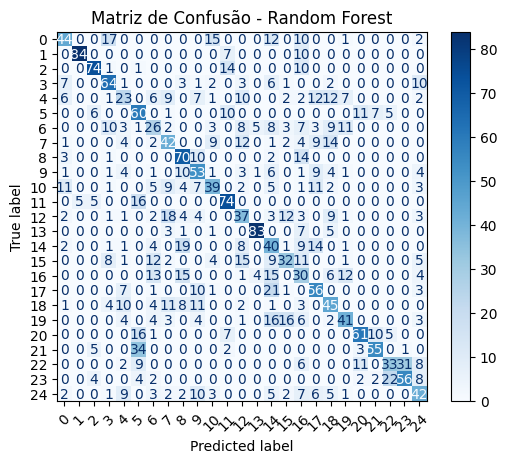

c:\Users\Win\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Win\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


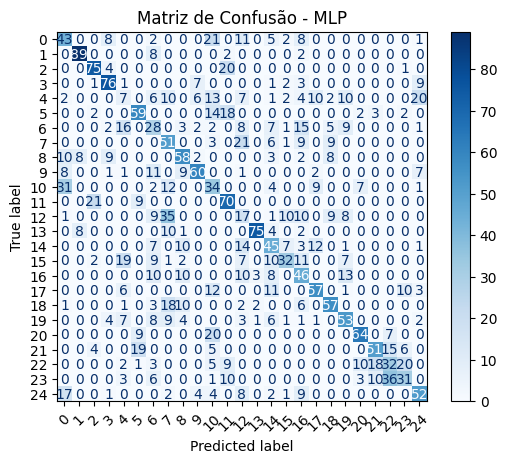

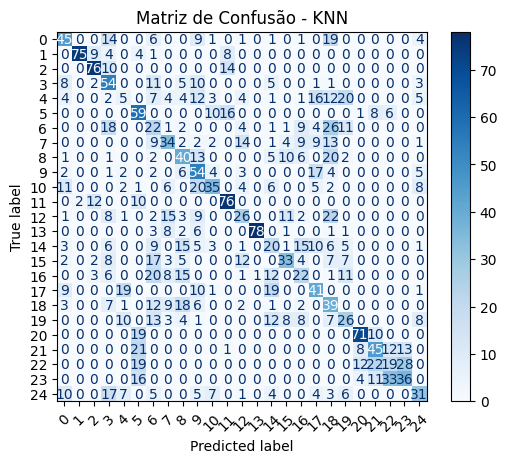

In [115]:
# lista de modelos e nomes para iteração
modelos = [
    ("Random Forest", modelo_rf),
    ("MLP", modelo_mlp),
    ("KNN", modelo_knn)
]

# pra cada modelo, gera a matriz de confusão e plota
for nome, modelo in modelos:
    # cross_val_predict retorna as previsões usando validação cruzada
    y_pred = cross_val_predict(modelo, X, y_encoded, groups=groups, cv=validador)
    
    # matriz de confusão
    cm = confusion_matrix(y_encoded, y_pred, labels=np.unique(y_encoded))
    
    # plotando a matriz
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_encoded))
    disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
    plt.title(f"Matriz de Confusão - {nome}")
    plt.show()

## K-means e hierárquico

In [116]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import adjusted_rand_score, silhouette_score

# normaliza
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# K-means
kmeans = KMeans(n_clusters=len(df_features_mov["sinal"].unique()), random_state=42, n_init=18)
labels_kmeans = kmeans.fit_predict(X_scaled)

# Cluster hierárquico (Ward linkage)
hier = AgglomerativeClustering(n_clusters=len(df_features_mov["sinal"].unique()), linkage="ward")
labels_hier = hier.fit_predict(X_scaled)

# Avaliação com métricas externas (usam os rótulos reais)
y_true = df_features_mov["sinal"]
print("K-means ARI:", adjusted_rand_score(y_true, labels_kmeans))
print("Hierárquico ARI:", adjusted_rand_score(y_true, labels_hier))

# Avaliação interna (sem rótulo) – quão bem os clusters se separam
print("K-means Silhouette:", silhouette_score(X_scaled, labels_kmeans))
print("Hierárquico Silhouette:", silhouette_score(X_scaled, labels_hier))


K-means ARI: 0.1621965429694299
Hierárquico ARI: 0.1554757438581443
K-means Silhouette: 0.15319908167157792
Hierárquico Silhouette: 0.14493358434858272


Avaliação do K-means com o valor de K no teste do cotovelo e, com  esse valor, comparar com o hierárquico

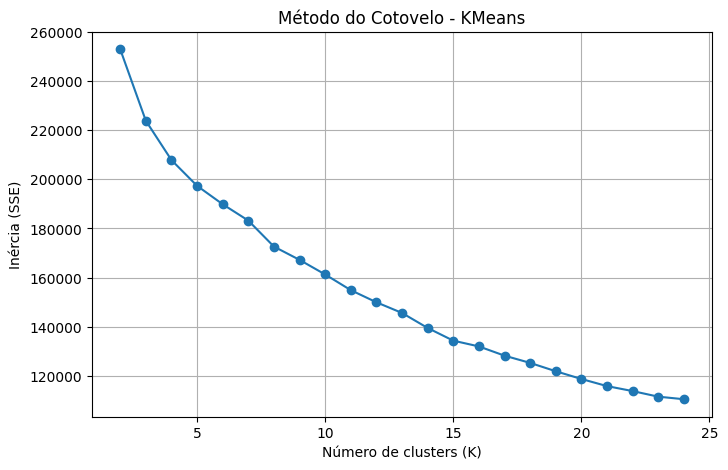

In [120]:
import matplotlib.pyplot as plt

# lista para armazenar a inércia
inertias = []
K_range = range(2, 25)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=18)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)

# gráfico do cotovelo
plt.figure(figsize=(8,5))
plt.plot(K_range, inertias, marker='o')
plt.xlabel("Número de clusters (K)")
plt.ylabel("Inércia (SSE)")
plt.title("Método do Cotovelo - KMeans")
plt.grid(True)
plt.show()


Quanto K está entre 5 e 10 a curva começa a estabilizar mais. Vou escolher K = 7.

In [118]:
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import adjusted_rand_score, silhouette_score

# número de clusters definido pelo cotovelo
k_otimo = 7  

# --- KMeans com K=7 ---
kmeans = KMeans(n_clusters=k_otimo, random_state=42, n_init=18)
labels_kmeans = kmeans.fit_predict(X_scaled)

# --- Hierárquico (Ward) com K=7 ---
hier = AgglomerativeClustering(n_clusters=k_otimo, linkage="ward")
labels_hier = hier.fit_predict(X_scaled)

# --- Avaliação ---
y_true = df_features_mov["sinal"]

print("== Comparação com K=7 ==")
print("K-means ARI:", adjusted_rand_score(y_true, labels_kmeans))
print("Hierárquico ARI:", adjusted_rand_score(y_true, labels_hier))

print("K-means Silhouette:", silhouette_score(X_scaled, labels_kmeans))
print("Hierárquico Silhouette:", silhouette_score(X_scaled, labels_hier))


== Comparação com K=7 ==
K-means ARI: 0.08785303386323744
Hierárquico ARI: 0.05308629685651954
K-means Silhouette: 0.14974655980585327
Hierárquico Silhouette: 0.18954965862533785


Nos resultados anteriores (com k = número de classes) o ARI foi razoavelmente próximo pros dois modelos, o que indica que eles chegaram a uma estrutura de clusters mais alinhada com os rótulos reais. O sillhouette ficou baixo, mas próximo também entre os dois, mostrando que os clusters não se separam bem de forma específica.

Com k fixado em 7 o ARI caiu bastante, ou seja, nesse valor os clusters se afastaram dos rótulos reais (as classes não são bem representadas com 7 clusters). Já o silhouette melhorou pro hierárquico, mostrando que mesmo setando menos alinhado aos rótulos, o hierárquico conseguiu formar clusters mais bem separados internamente. Pro k-means o silhouette se manteve parecido.

Esses resultados são coerentes já que quando usamos o número de clusters = número de classes reais, os métodos ficam mais próximos da verdade (ARI maior).

Próximo passo: Na execução do Hierárquico, varie 2 métodos do linkage, com o mesmo valor de k.

In [119]:
from sklearn.cluster import AgglomerativeClustering

k_otimo = 7

# linkage = ward
hier_ward = AgglomerativeClustering(n_clusters=k_otimo, linkage="ward")
labels_hier_ward = hier_ward.fit_predict(X_scaled)

# linkage = complete
hier_complete = AgglomerativeClustering(n_clusters=k_otimo, linkage="complete")
labels_hier_complete = hier_complete.fit_predict(X_scaled)

# linkage = average
hier_average = AgglomerativeClustering(n_clusters=k_otimo, linkage="average")
labels_hier_average = hier_average.fit_predict(X_scaled)

# métricas
print("== Hierárquico com K=7 ==")
print("Ward   - ARI:", adjusted_rand_score(y_true, labels_hier_ward))
print("Ward   - Silhouette:", silhouette_score(X_scaled, labels_hier_ward))

print("Complete - ARI:", adjusted_rand_score(y_true, labels_hier_complete))
print("Complete - Silhouette:", silhouette_score(X_scaled, labels_hier_complete))

print("Average  - ARI:", adjusted_rand_score(y_true, labels_hier_average))
print("Average  - Silhouette:", silhouette_score(X_scaled, labels_hier_average))


== Hierárquico com K=7 ==
Ward   - ARI: 0.05308629685651954
Ward   - Silhouette: 0.18954965862533785
Complete - ARI: 0.0007692023477013102
Complete - Silhouette: 0.27237871026614874
Average  - ARI: 1.874954963546379e-05
Average  - Silhouette: 0.5365035578330963


WARD:
- ARI = 0.053 é muito baixo, então o agrupamento não reproduziu bem a estrutura real das classes;
- Silhouette = 0.189 também reflete uma separação fraca

COMPLETE:
- ARI = 0.00077 é ainda mais baixo, praticamente aleatório, ou seja, não conseguiu agrupar de forma consistente com os rótulos verdadeiros;
- Silhouette = 0.272 foi melhor que o Ward, os grpos ficaram mais coesos e separados mesmo sem corresponder bem às classes reais

AVERAGE:
- ARI = 0.0000187 muito próximo de zero, a correspondência com as classes pode ser considerada inexistente
- Silhouette = 0.536 foi o melhor resultado de separação interna entre todos os métodos, os clusters ficaram bem definidos

#### Comparação final

Todos os métodos ficaram com ARI baixo, indicando que nenhum agrupamento conseguiu reproduzir bem as classes reais. Nessa medida, o k-means foi melhor que qualquer versão do hierárquico.

Na silhouette, o hierárquico average se destacou mostrando grande separação e coesão dos grupos formados (mesmo que não batam com as classes reais), e o complete também foi relativamente bom (superior ao k-means, pelo menos)